In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

import sys

In [71]:
CL, MER, NMUTS = "common", 15, 2
CONFIG = os.path.join(os.path.dirname(os.getcwd()), "config.ini")
PATH="/wynton/home/ahituv/fongsl/nullomers/data/lock/common/concatmers/sei_predictions/chromatin-profiles-hdf5/"
COORS = [
    "chr10:133080140-133080340",  # inactive
    'chr1:206663895-206664095',  # inactive
    "chr15:45387502-45387702",  # inactive
    
    "chr12:50933777-50933977",  # active
    "chr16:22922244-22922444",   # active
    "chr6:73520947-73521147",   # active
    "chr8:41156753-41156953"   # active
]

INACTIVE = [    "chr10:133080140-133080340",  # inactive
    'chr1:206663895-206664095',  # inactive
    "chr15:45387502-45387702",  # inactive
           ]

# predict sequence classes

In [6]:
os.chdir("/wynton/home/ahituv/fongsl/bin/sei-framework")

for COOR in COORS:
    
    # results file
    OUT =  os.path.join(PATH,
                 f"common.15mers.2mut.nulls.fo.pam.CONCAT-10.ext4096.{COOR}.raw_sequence_class_scores.npy")
    
    # infile
    F = os.path.join(
        PATH, f"common.{MER}mers.{NMUTS}mut.nulls.fo.pam.CONCAT-10.ext4096.{COOR}_predictions.h5")
    
    # sei part 2 command
    cmd = [
            "bash /wynton/home/ahituv/fongsl/bin/sei-framework/2_raw_sc_score.sh",
            F, 
            PATH
            ]

    # if not already run
    if os.path.exists(OUT) is False:
        print(" ".join(cmd))
        os.system(" ".join(cmd))

# analyze data

## load labels

In [52]:
def processLabel(label_file):
    
    # read label file as pd dataframe
    lab = pd.read_csv(label_file,sep ='\t')
    lab = lab.drop(columns = ["index"])  # redundant index column
    
    # rename the first col. This is the endogenous sequence
    lab["name"].iloc[0] = f"{COOR}_-1_endog"
    
    # str splitting
    # coordinates
    lab["coor"]= lab["name"].apply(lambda x: x.split("_")[0] if "_" in x else None)

    # the concat number
    lab["concat_id"]= lab["name"].apply(lambda x: ".".join(x.split("_")[1:]))
    lab["concat_id_number"]= lab["name"].apply(lambda x: x.split("_")[1]).map(int)
    
    # the type (endogenous, kmer, nullomer )
    lab["concat_type"]= lab["name"].apply(lambda x: x.split("_")[2])
    
    lab["c"] = "b"
    
    lab.loc[lab["concat_type"].str.contains("endog"), "c"] = "r"
    lab.loc[lab["concat_type"].str.contains("kmer"), "c"] = "y"
    
    return lab

In [47]:
def returnSequenceClassLabels():
    file="/wynton/home/ahituv/fongsl/bin/sei-framework/sequence_class_labels.csv"
    lab = pd.read_csv(file)
    
    return lab

In [48]:
"""
# get sequence class labels. See Methods section of Chen 2022 for interpretation of these PC labels.
# apparently labels >40 are low active/heterochromatin. 
#Make up <2% of the genome. But 2% of the genome can still be significant.
"""

seqClass = returnSequenceClassLabels()

seqClass.head()

,#Sequence class label,Sequence class name,Rank by size,Group
0,PC1,Polycomb / Heterochromatin,0,PC
1,L1,Low signal,1,L
2,TN1,Transcription,2,TN
3,TN2,Transcription,3,TN
4,L2,Low signal,4,L


In [53]:
datas = {}
for COOR in COORS:
    # open npy data
    data = np.load(
        os.path.join(PATH,
                 f"common.15mers.2mut.nulls.fo.pam.CONCAT-10.ext4096.{COOR}.raw_sequence_class_scores.npy"),
                allow_pickle=True)
    labels = os.path.join(PATH, 
                     f"common.15mers.2mut.nulls.fo.pam.CONCAT-10.ext4096.{COOR}_row_labels.txt")

    # turn into pd dataframe
    df = pd.DataFrame(data)
    
    # rename columns
    df.columns = list(seqClass["#Sequence class label"])[:-1]
    
    # process labels file
    lab = processLabel(labels)
    
    ## add labels and data together
    df = pd.merge(lab, df, left_index=True, right_index=True)

    datas[COOR]= df

## combine results

In [54]:
df = pd.concat(datas.values())

df.head()

,name,coor,concat_id,concat_id_number,concat_type,c,PC1,L1,TN1,TN2,...,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET
0,chr10:133080140-133080340_-1_endog,chr10:133080140-133080340,-1.endog,-1,endog,r,6.482182,3.249681,2.447702,2.717271,...,0.042906,1.150516,4.432318,5.584652,2.107701,2.672769,3.682160,2.677110,3.495075,3.912445
1,chr10:133080140-133080340_1_concat-null,chr10:133080140-133080340,1.concat-null,1,concat-null,b,6.183464,3.118330,2.713802,2.839614,...,0.047606,1.319265,5.166355,5.425963,1.984890,2.883699,4.535702,2.611302,3.187604,4.254385
2,chr10:133080140-133080340_1_concat-kmer,chr10:133080140-133080340,1.concat-kmer,1,concat-kmer,y,6.239453,3.171999,3.112989,3.197493,...,0.047745,1.321789,5.021655,5.515739,2.007824,2.747476,4.383468,2.757899,3.307534,4.091720
3,chr10:133080140-133080340_2_concat-null,chr10:133080140-133080340,2.concat-null,2,concat-null,b,7.069335,3.608191,3.202336,3.309253,...,0.048920,1.496726,5.892833,6.020467,2.351188,3.412969,4.809049,2.949658,3.507294,4.885540
4,chr10:133080140-133080340_2_concat-kmer,chr10:133080140-133080340,2.concat-kmer,2,concat-kmer,y,7.010955,3.626810,3.186181,3.335327,...,0.050829,1.385264,5.334833,5.957517,2.289851,3.010276,4.542644,2.919258,3.685547,4.431013


# PCA 

In [16]:
pca = PCA(n_components=2)

In [17]:
X, y = df[list(df)[5:45]], df[list(df)[:5]]
y

,name,coor,concat_id,concat_type,c
0,chr10:133080140-133080340_-1_endog,chr10:133080140-133080340,-1.endog,endog,r
1,chr10:133080140-133080340_1_concat-null,chr10:133080140-133080340,1.concat-null,concat-null,b
2,chr10:133080140-133080340_1_concat-kmer,chr10:133080140-133080340,1.concat-kmer,concat-kmer,y
3,chr10:133080140-133080340_2_concat-null,chr10:133080140-133080340,2.concat-null,concat-null,b
4,chr10:133080140-133080340_2_concat-kmer,chr10:133080140-133080340,2.concat-kmer,concat-kmer,y
...,...,...,...,...,...
16000,chr8:41156753-41156953_8000_concat-kmer,chr8:41156753-41156953,8000.concat-kmer,concat-kmer,y
16001,chr8:41156753-41156953_8001_concat-null,chr8:41156753-41156953,8001.concat-null,concat-null,b
16002,chr8:41156753-41156953_8001_concat-kmer,chr8:41156753-41156953,8001.concat-kmer,concat-kmer,y
16003,chr8:41156753-41156953_8002_concat-null,chr8:41156753-41156953,8002.concat-null,concat-null,b


In [18]:
X

,PC1,L1,TN1,TN2,L2,E1,E2,E3,L3,E4,...,E10,TF4,HET4,L7,PC4,HET5,E11,TF5,E12,HET6
0,6.482182,3.249681,2.447702,2.717271,2.327597,2.238897,2.171775,2.628973,4.452637,1.565991,...,1.836911,1.284182,5.360318,1.462608,3.132465,1.269848,2.415537,1.753370,1.756911,0.520774
1,6.183464,3.118330,2.713802,2.839614,2.388879,1.648716,1.705572,2.091077,4.791674,1.047894,...,1.789563,1.133129,6.238221,1.863442,2.293423,1.643429,2.042949,1.549798,1.541749,0.680231
2,6.239453,3.171999,3.112989,3.197493,2.314096,1.757548,1.836024,2.222911,4.818022,1.122384,...,1.900859,1.182098,6.006309,1.740426,2.496108,1.550516,2.155421,1.655200,1.608286,0.647729
3,7.069335,3.608191,3.202336,3.309253,2.725402,1.887302,1.973553,2.447114,5.124232,1.185968,...,1.853249,1.266158,7.279461,2.073701,2.777778,1.807451,2.343158,1.813646,1.787400,0.727778
4,7.010955,3.626810,3.186181,3.335327,2.570305,2.172008,2.099837,2.583747,5.120929,1.396515,...,1.970907,1.348068,6.702960,1.886544,3.172782,1.657862,2.479091,1.867631,1.878779,0.673140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16000,7.662255,3.391543,1.914996,2.318242,1.287338,5.832050,5.064692,4.421478,4.894295,5.589330,...,2.544257,2.085053,3.863820,1.099671,5.453306,1.164527,4.592004,2.822577,5.051708,0.541606
16001,8.001386,3.271159,2.202346,2.498882,1.358372,5.088524,4.997580,4.188116,5.006704,6.200764,...,2.171586,2.072828,4.654726,1.233543,4.485463,1.572253,4.642967,3.000865,9.043920,0.679933
16002,5.485659,2.074228,2.029815,2.162144,0.714193,2.476915,3.419506,2.561564,3.919765,2.341989,...,1.050511,1.038451,2.929342,0.701699,2.740723,0.545254,2.416367,1.700914,2.191827,0.247113
16003,4.512173,2.098466,1.732739,2.007023,0.756263,2.948461,3.605752,2.675657,3.539173,2.690254,...,1.112488,1.147059,2.463839,0.837178,2.842022,0.673835,2.442724,1.688092,2.455644,0.302095


In [19]:
Xt = pca.fit_transform(df[list(df)[5:45]])
pca.explained_variance_ratio_

array([0.96772208, 0.01577764])

In [74]:
y

,name,coor,concat_id,concat_type,c
0,chr10:133080140-133080340_-1_endog,chr10:133080140-133080340,-1.endog,endog,y
1,chr10:133080140-133080340_1_concat-null,chr10:133080140-133080340,1.concat-null,concat-null,y
2,chr10:133080140-133080340_1_concat-kmer,chr10:133080140-133080340,1.concat-kmer,concat-kmer,y
3,chr10:133080140-133080340_2_concat-null,chr10:133080140-133080340,2.concat-null,concat-null,y
4,chr10:133080140-133080340_2_concat-kmer,chr10:133080140-133080340,2.concat-kmer,concat-kmer,y
...,...,...,...,...,...
16000,chr8:41156753-41156953_8000_concat-kmer,chr8:41156753-41156953,8000.concat-kmer,concat-kmer,r
16001,chr8:41156753-41156953_8001_concat-null,chr8:41156753-41156953,8001.concat-null,concat-null,r
16002,chr8:41156753-41156953_8001_concat-kmer,chr8:41156753-41156953,8001.concat-kmer,concat-kmer,r
16003,chr8:41156753-41156953_8002_concat-null,chr8:41156753-41156953,8002.concat-null,concat-null,r


In [72]:
y["c"] = "b"

y.loc[~y["coor"].isin(INACTIVE), "c"] = "r"
y.loc[y["coor"].isin(INACTIVE), "c"] = "y"

[Text(0.5, 0, 'PC1-0.97'),
 Text(0, 0.5, 'PC1-0.02'),
 Text(0.5, 1.0, 'label encoded sequence PCA')]

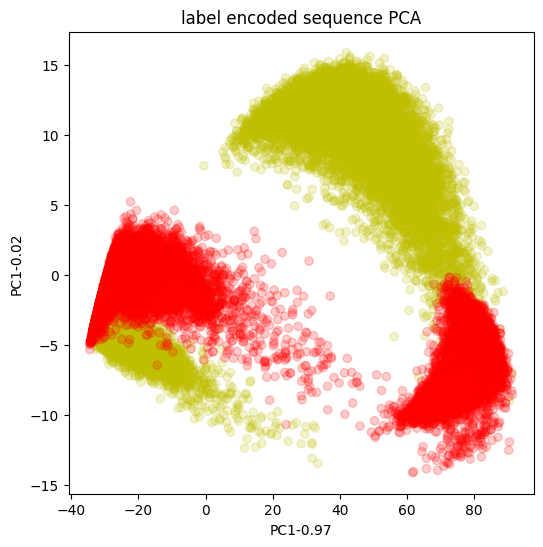

In [73]:
fig, ax= plt.subplots(figsize=(6,6))
plt.scatter(np.array(Xt)[:,0], np.array(Xt)[:,1],  
            c=(y["c"]),
            alpha=0.2)
ax.set(xlabel=f"PC1-{round(pca.explained_variance_ratio_[0],2)}",
       ylabel=f"PC1-{round(pca.explained_variance_ratio_[1],2)}",
       title="label encoded sequence PCA"
)

# heat map

In [56]:
df.loc[(df["concat_id_number"]==1)| (df["concat_id_number"]==-1), 
                list(df)[:44]].sort_values(by="concat_id")

,name,coor,concat_id,concat_id_number,concat_type,c,PC1,L1,TN1,TN2,...,TN4,HET3,E10,TF4,HET4,L7,PC4,HET5,E11,TF5
0,chr10:133080140-133080340_-1_endog,chr10:133080140-133080340,-1.endog,-1,endog,r,6.482182,3.249681,2.447702,2.717271,...,3.334962,4.111442,1.836911,1.284182,5.360318,1.462608,3.132465,1.269848,2.415537,1.753370
0,chr8:41156753-41156953_-1_endog,chr8:41156753-41156953,-1.endog,-1,endog,r,1.666308,1.556214,0.558354,0.884454,...,0.769935,1.425835,0.743237,0.781192,1.394160,0.620902,1.488119,0.354673,1.311262,0.942450
0,chr1:206663895-206664095_-1_endog,chr1:206663895-206664095,-1.endog,-1,endog,r,15.366208,9.091540,4.215595,5.477120,...,5.218499,5.027758,9.706249,6.902284,6.821299,2.864892,14.366849,3.767941,20.653798,8.172729
0,chr6:73520947-73521147_-1_endog,chr6:73520947-73521147,-1.endog,-1,endog,r,9.681533,6.467166,4.226597,4.678774,...,4.553813,4.502370,10.476438,8.867321,6.733261,3.178491,6.926714,11.759428,18.228869,11.151450
0,chr15:45387502-45387702_-1_endog,chr15:45387502-45387702,-1.endog,-1,endog,r,1.442957,2.708474,1.288940,1.778923,...,0.795445,1.001410,2.369303,2.910065,1.040438,0.530540,1.987005,0.790223,2.702060,11.206530
0,chr16:22922244-22922444_-1_endog,chr16:22922244-22922444,-1.endog,-1,endog,r,1.433577,1.098763,0.202435,0.408190,...,0.302005,1.065397,0.433431,0.348505,0.852229,0.267750,1.235229,0.116676,0.633057,0.498880
0,chr12:50933777-50933977_-1_endog,chr12:50933777-50933977,-1.endog,-1,endog,r,3.166821,2.487803,1.941712,2.200844,...,1.919622,1.840171,1.348550,1.527436,1.734370,0.869475,2.266706,0.591974,4.039957,2.205238
2,chr6:73520947-73521147_1_concat-kmer,chr6:73520947-73521147,1.concat-kmer,1,concat-kmer,y,15.182599,8.648743,6.063208,6.583894,...,6.760425,6.380296,11.939509,9.890211,10.210478,3.778318,9.883284,12.676018,23.336986,12.863180
2,chr16:22922244-22922444_1_concat-kmer,chr16:22922244-22922444,1.concat-kmer,1,concat-kmer,y,5.845751,1.938649,0.736476,0.970105,...,1.763288,1.973319,0.743097,0.630435,3.443420,1.234131,2.764223,1.332756,1.523268,0.967261
2,chr12:50933777-50933977_1_concat-kmer,chr12:50933777-50933977,1.concat-kmer,1,concat-kmer,y,6.626962,2.451669,3.674239,3.383050,...,4.500256,1.965438,1.217079,1.243925,3.758654,1.412601,2.783473,1.431922,4.115666,2.147080


{'endog': 'r', 'concat-kmer': 'y', 'concat-null': 'b'}
{'endog': 'r', 'concat-kmer': 'y', 'concat-null': 'b'}
{'endog': 'r', 'concat-kmer': 'y', 'concat-null': 'b'}
{'endog': 'r', 'concat-kmer': 'y', 'concat-null': 'b'}


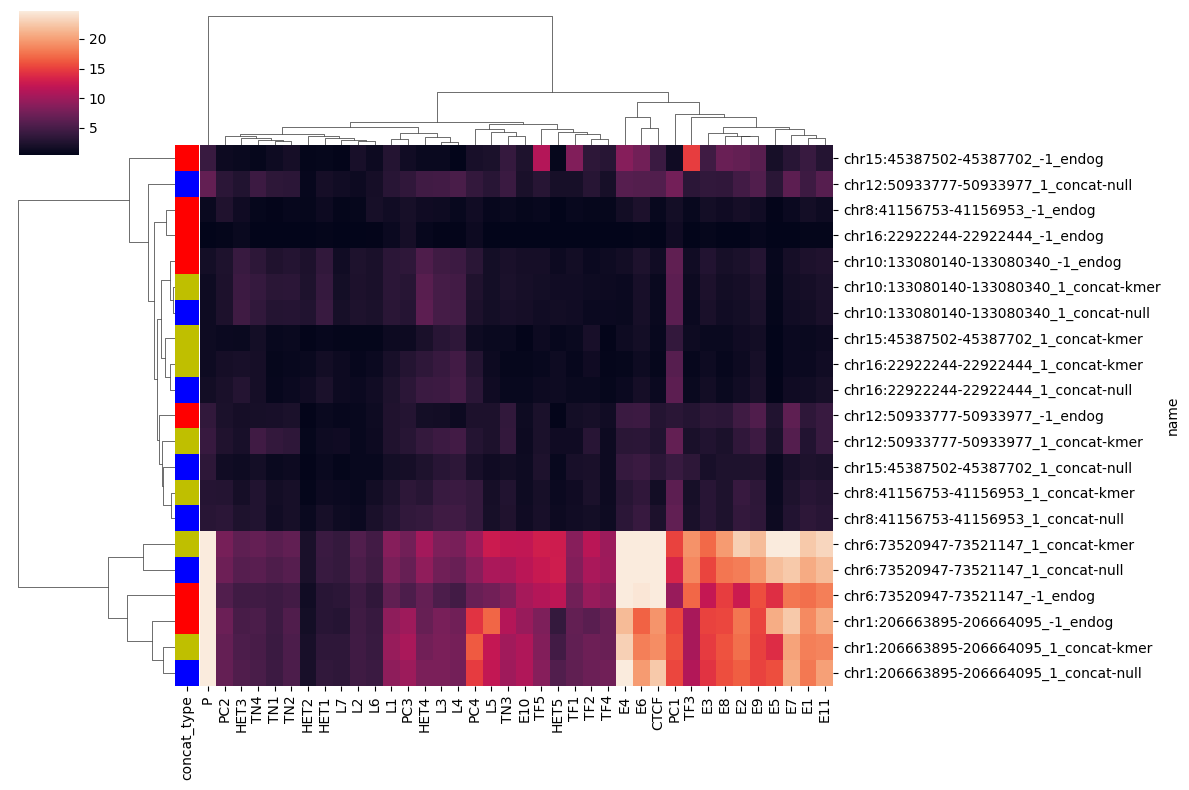

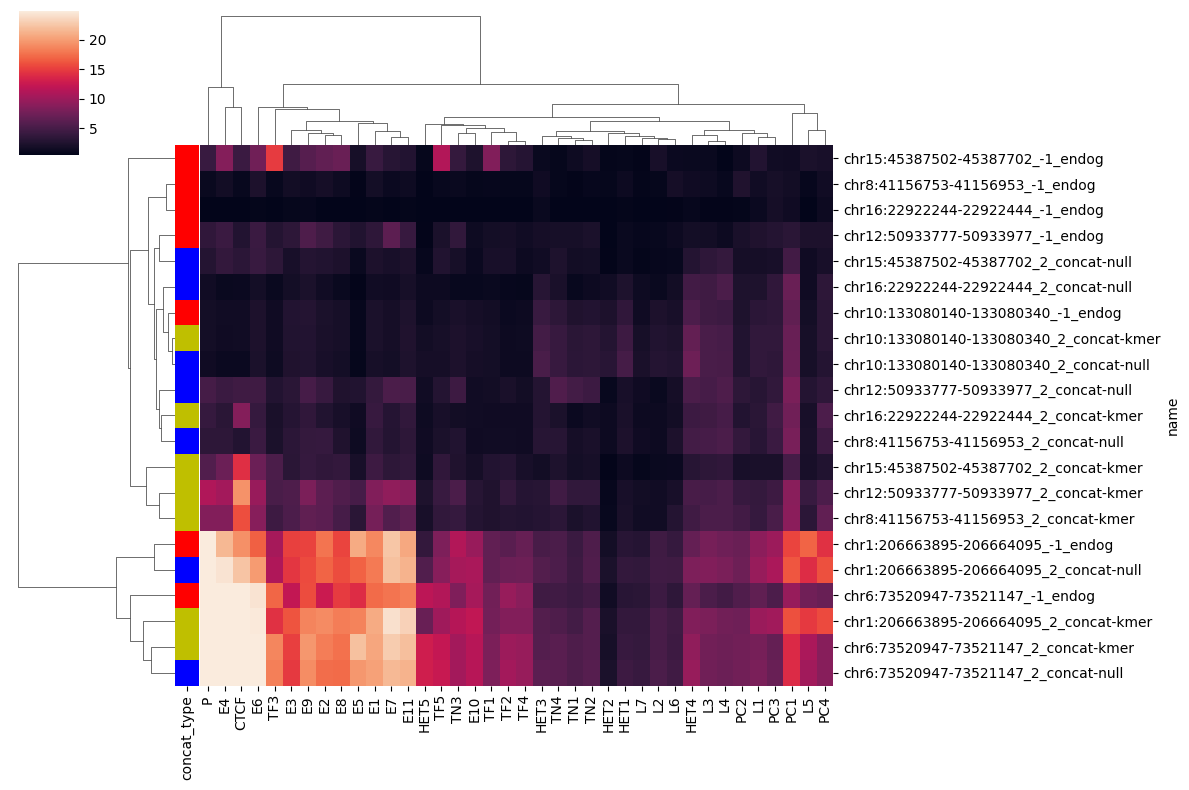

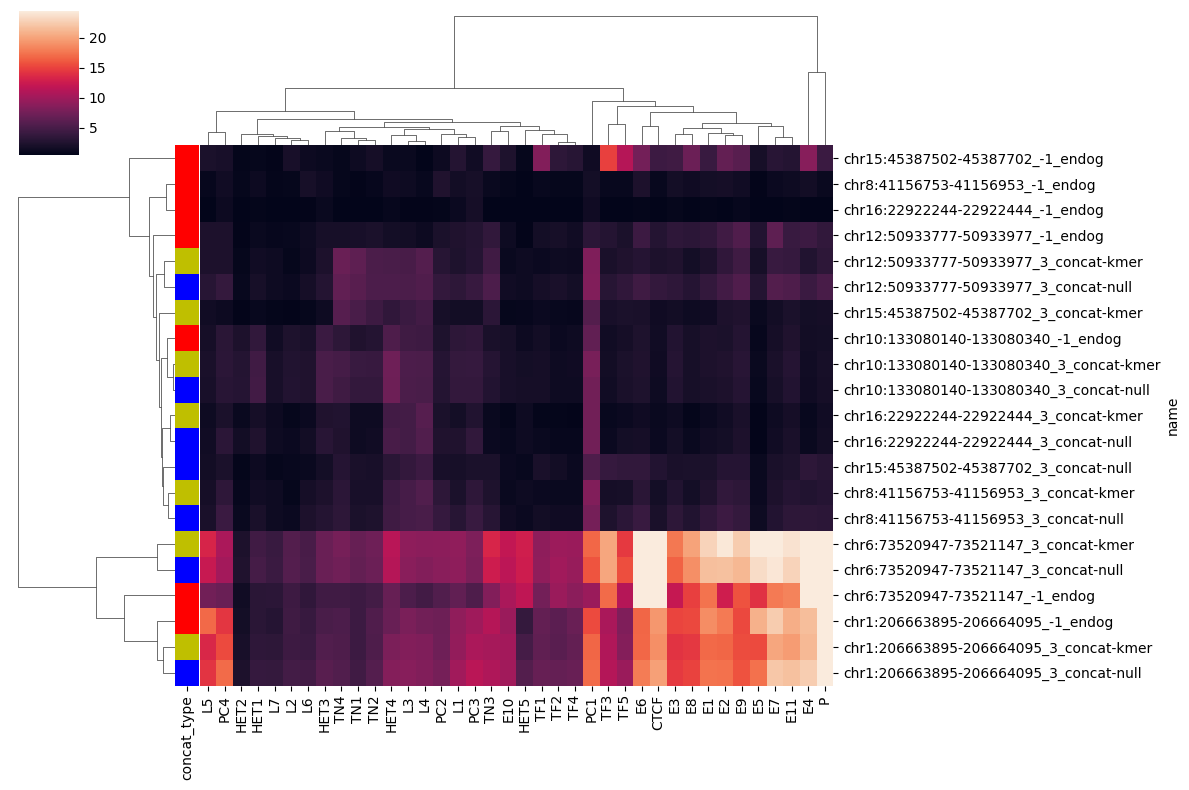

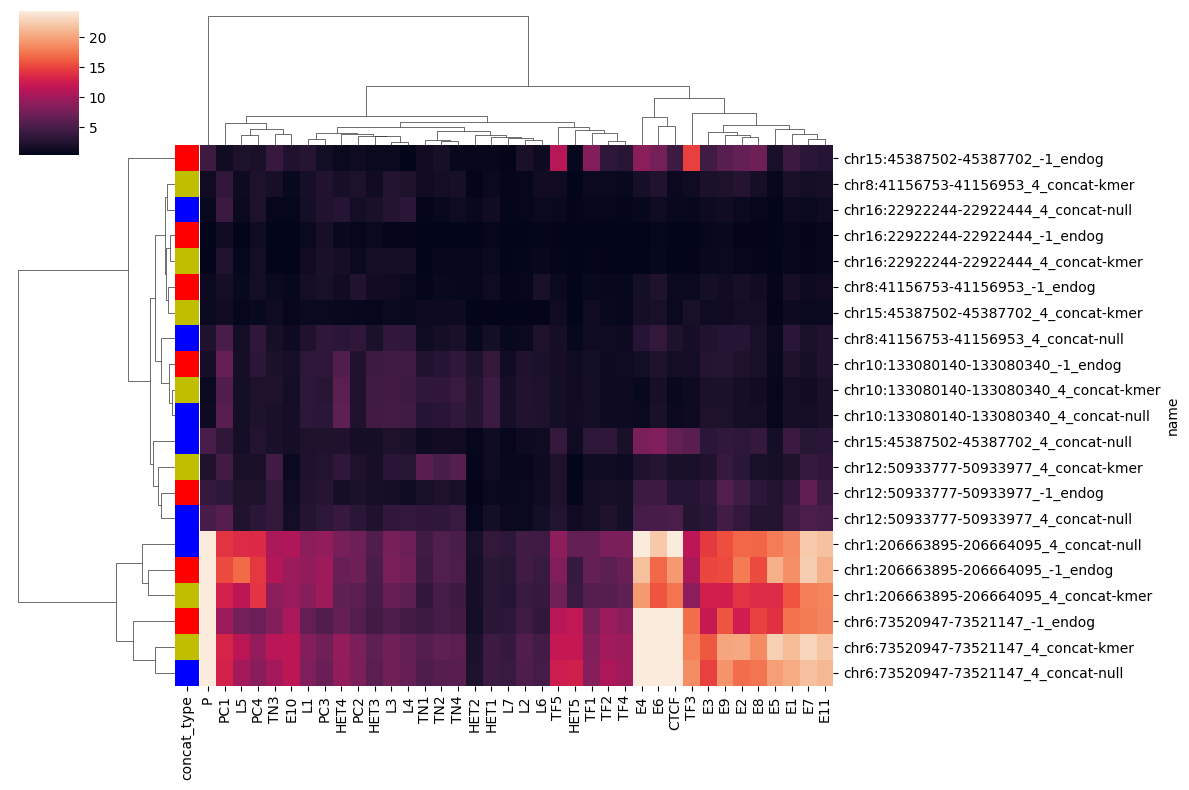

In [70]:
max_concat_n =df["concat_id_number"].max() 
for i in np.arange(max_concat_n):

    test=df.loc[(df["concat_id_number"]==i+1)| (df["concat_id_number"]==-1), 
                list(df)[:44]].sort_values(by="concat_id")
    test=test.set_index("name")


    lut = dict(zip(test["concat_type"].unique(), "ryb"))
    print(lut)
    row_colors = test.concat_type.map(lut)

    cm = sns.clustermap(test[test.columns[5:]].drop_duplicates(), 
                       row_colors=row_colors,
                       figsize=(12,8),
                        robust=True,
                        #row_cluster=False,
                       )

    plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)

    if i>2:
        break

# differences

In [90]:
from scipy import stats

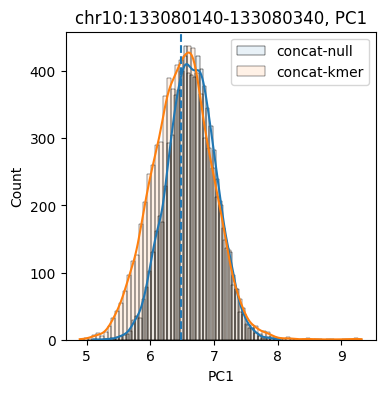

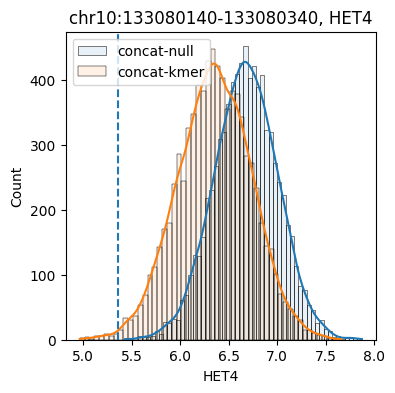

In [112]:
for COOR in COORS:
    c = df.loc[df["coor"]==COOR]
    for col in list(c)[6:46]:

        null=c.loc[c["concat_type"]=="concat-null"]
        kmer=c.loc[c["concat_type"]=="concat-kmer"]
        endo=c.loc[c["concat_type"]=="endog"]
        
        # test if kmer is sig dif from null pc distribution
        s, p = stats.mannwhitneyu(null[col], kmer[col])
        
        # if significant, plot
        if p<0.05 and null[col].mean()>5:
            fig, ax = plt.subplots(figsize=(4,4))

            sns.histplot(null[col], label="concat-null", alpha=0.1, kde=True)
            sns.histplot(kmer[col], label="concat-kmer", alpha=0.1, kde=True)
            ax.axvline(c.loc[c["concat_type"]=="endog", col].iloc[0], ls="--")
            ax.set(title=f"{COOR}, {col}")
            ax.legend()
            plt.show()
            plt.close()
    break

